<a href="https://colab.research.google.com/github/AshKanishk/ImageClassification/blob/master/Flowerimageclassification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

TensorFlow 2.x selected.


In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(name="tf_flowers", 
                                                            with_info=True,
                                                            split=list(splits),                                         
                                                            as_supervised=True)

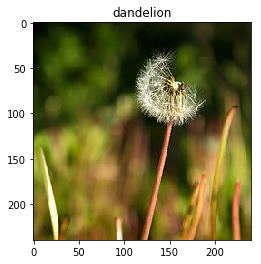

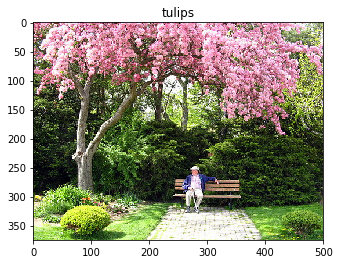

In [0]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [0]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch,label_batch in train_batches.take(1) :
  pass
image_batch.shape

TensorShape([32, 160, 160, 3])

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model Inception V3
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

feature_batch = base_model(image_batch)

In [0]:
base_model.summary()


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [0]:
prediction_layer = keras.layers.Dense(metadata.features['label'].num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
93/93 [==============================] - 26s 280ms/step - loss: 1.2198 - accuracy: 0.5197 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
93/93 [==============================] - 17s 185ms/step - loss: 0.8526 - accuracy: 0.7014 - val_loss: 1.6029 - val_accuracy: 0.6472
Epoch 3/10
93/93 [==============================] - 17s 185ms/step - loss: 0.7539 - accuracy: 0.7397 - val_loss: 1.4137 - val_accuracy: 0.6806
Epoch 4/10
93/93 [==============================] - 18s 190ms/step - loss: 0.6873 - accuracy: 0.7637 - val_loss: 1.9975 - val_accuracy: 0.6167
Epoch 5/10
93/93 [==============================] - 17s 186ms/step - loss: 0.6491 - accuracy: 0.7817 - val_loss: 1.9247 - val_accuracy: 0.6333
Epoch 6/10
93/93 [==============================] - 17s 185ms/step - loss: 0.6067 - accuracy: 0.7861 - val_loss: 1.9093 - val_accuracy: 0.6250
Epoch 7/10
93/93 [==============================] - 18s 191ms/step - loss: 0.6071 - accuracy: 0.7837 - val_loss: 2.3964 - val_accuracy

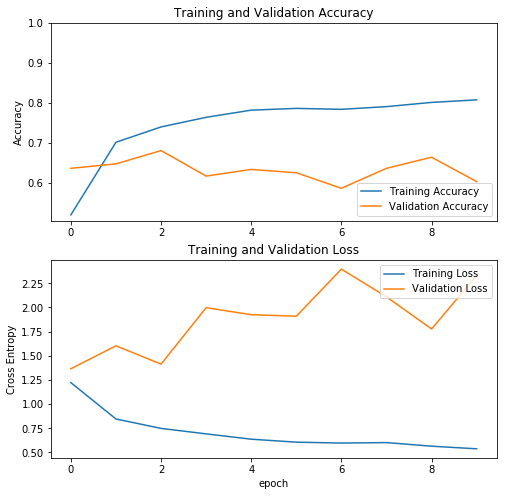

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
base_model.trainable = True

In [0]:
fine_tune_at = 250
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [0]:
model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()
initial_epochs=10
total_epochs = initial_epochs + 10

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,551,685
Non-trainable params: 11,261,344
_________________________________________________________________
Epoch 11/20
93/93 [==============================] - 29s 312ms/step - loss: 0.7914 - accuracy: 0.7627 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 12/20
93/93 [==============================] - 20s 215ms/step - loss: 0.3352 - accuracy: 0.8980 - val_loss: 1.2386 - val_accuracy: 0.7556
Epoch 13/20
93/93 [==============================] - 20s 213ms/step -

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

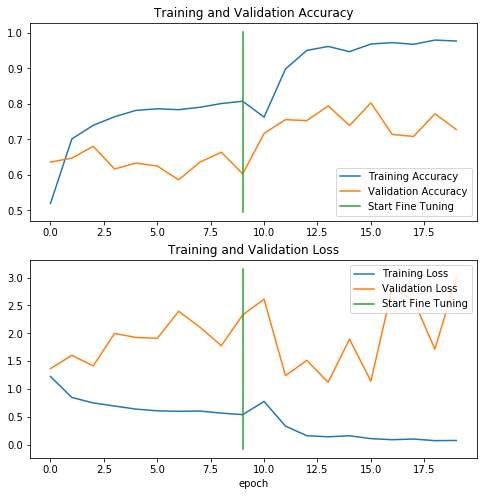

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()